In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as mp
from __future__ import print_function
%matplotlib inline

In [2]:
def simulate(n_gal, n_star, abs_true, s_true, mu_bar, mu_sig, mu_hat_sig, m_sig_int, m_hat_sig):
    
    # distance moduli
    mu_true = np.sort(npr.randn(n_gal) * mu_sig + mu_bar)
    mu_hat = mu_true[0] + npr.randn(1) * mu_hat_sig
    
    # log periods and apparent magnitudes
    lp_true = np.reshape(1.0 + npr.rand(n_gal * n_star), (n_gal, n_star))
    m_true = np.zeros((n_gal, n_star))
    for i in range(n_gal):
        m_true[i, :] = mu_true[i] + abs_true + s_true * lp_true[i, :]
    m_hat = m_true + npr.randn(n_gal * n_star).reshape(n_gal, n_star) * m_hat_sig
    
    return (mu_true, lp_true, m_true, mu_hat, m_hat)

In [3]:
# setup
n_gal = 2
n_star = 200
n_samples = 50000

abs_bar = -26.0
abs_sig = 4.0
s_bar = -1.0
s_sig = 1.0
mu_bar = 30.0
mu_sig = 5.0

mu_hat_sig = 0.01
m_sig_int = 0.05
m_hat_sig = 0.02

mu_true, lp_true, m_true, mu_hat, m_hat = simulate(n_gal, n_star, abs_bar, s_bar, mu_bar, mu_sig, mu_hat_sig, m_sig_int, m_hat_sig)

Text(0,0.5,'$N \\left(m_{ij} - \\hat{m}_{ij}\\right)$')

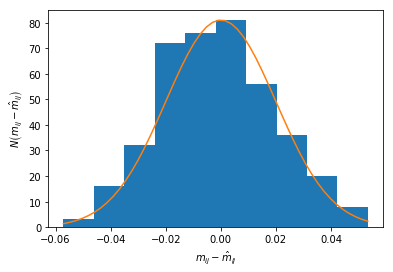

In [4]:
outs = mp.hist((m_true - m_hat).flatten())
dm_grid = np.linspace(np.min(outs[1]), np.max(outs[1]))
mp.plot(dm_grid, np.exp(-0.5 * (dm_grid/m_hat_sig) ** 2) * np.max(outs[0]))
mp.xlabel(r'$m_{ij} - \hat{m}_{ij}$')
mp.ylabel(r'$N \left(m_{ij} - \hat{m}_{ij}\right)$')

In [5]:
def gls_fit(n_gal, n_star, mu_hat, mu_hat_sig, m_hat, m_sig_int, m_hat_sig, \
            lp_true, priors=None):

    # setup
    # n_obs is one anchor constraint and one magnitude per Cepheid.
    # n_par is one mu per Cepheid host and 2 CPL params. if priors 
    # are used, we add on n_gal + 2 observations: one prior constraint 
    # on each host distance modulus and CPL parameter
    n_obs = n_gal * n_star + 1
    n_par = n_gal + 2
    if priors is not None:
        n_obs += n_gal + 2
    data = np.zeros(n_obs)
    design = np.zeros((n_obs, n_par))
    cov_inv = np.zeros((n_obs, n_obs))
    
    # anchor(s)
    data[0] = mu_hat
    design[0, 0] = 1.0
    cov_inv[0, 0] = 1.0 / mu_hat_sig ** 2

    # Cepheids
    k = 1
    for i in range(0, n_gal):
        for j in range(0, n_star):

            data[k] = m_hat[i, j]
            design[k, i] = 1.0
            design[k, n_gal] = 1.0
            design[k, n_gal + 1] = lp_true[i, j]
            cov_inv[k, k] = 1.0 / (m_hat_sig ** 2 + m_sig_int ** 2)
            k += 1
    
    # and, finally, priors if desired
    if priors is not None:
        abs_bar, abs_sig, s_bar, s_sig, mu_bar, mu_sig = priors
        for i in range(n_gal):
            data[k] = mu_bar
            design[k, i] = 1.0
            cov_inv[k, k] = 1.0 / mu_sig ** 2
            k += 1
        data[k] = abs_bar
        design[k, n_gal] = 1.0
        cov_inv[k, k] = 1.0 / abs_sig ** 2
        k += 1
        data[k] = s_bar
        design[k, n_gal + 1] = 1.0
        cov_inv[k, k] = 1.0 / s_sig ** 2
        k += 1
        
    # fit and return
    destci = np.dot(design.transpose(), cov_inv)
    pars_cov = np.linalg.inv(np.dot(destci, design))
    pars = np.dot(np.dot(pars_cov, destci), data)
    res = data - np.dot(design, pars)
    dof = n_obs - n_par
    chisq_dof = np.dot(res.transpose(), np.dot(cov_inv, res))
    return pars, pars_cov, chisq_dof

In [6]:
gls_pars, gls_pars_cov, gls_chisq = gls_fit(n_gal, n_star, mu_hat, mu_hat_sig, m_hat, \
                                            m_sig_int, m_hat_sig, lp_true, \
                                            priors=[abs_bar, abs_sig, s_bar, s_sig, mu_bar, mu_sig])

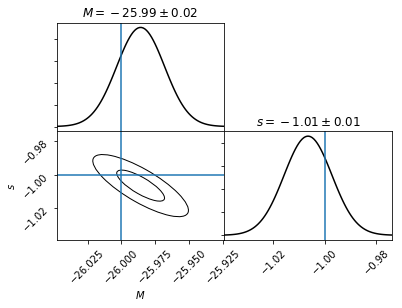

In [7]:
import scipy.stats as sps
import matplotlib.patches as mpp
def schmorner(par_mean, par_cov, par_true, par_label):
    
    # setup
    par_std = np.sqrt(np.diag(par_cov))
    x_min = par_mean[0] - 3.5 * par_std[0]
    x_max = par_mean[0] + 3.5 * par_std[0]
    y_min = par_mean[1] - 3.5 * par_std[1]
    y_max = par_mean[1] + 3.5 * par_std[1]
    fig, axes = mp.subplots(2, 2)
    
    # 1D marge
    x = np.linspace(x_min, x_max, 100)
    axes[0, 0].plot(x, sps.norm.pdf(x, par_mean[0], par_std[0]), 'k')
    axes[0, 0].axvline(par_true[0])
    axes[1, 0].axvline(par_true[0])
    axes[0, 0].set_xticklabels([])
    axes[0, 0].set_yticklabels([])
    axes[0, 0].set_xlim(x_min, x_max)
    axes[0, 0].set_title(par_label[0])
    axes[0, 0].set_title(par_label[0] + r'$=' + '{:6.2f}'.format(par_mean[0]) + \
                         r'\pm' + '{:4.2f}'.format(par_std[0]) + r'$')
    y = np.linspace(y_min, y_max, 100)
    axes[1, 1].plot(y, sps.norm.pdf(y, par_mean[1], par_std[1]), 'k')
    axes[1, 0].axhline(par_true[1])
    axes[1, 1].axvline(par_true[1])
    axes[1, 1].tick_params(labelleft=False)
    axes[1, 1].set_xlim(y_min, y_max)
    for tick in axes[1, 1].get_xticklabels():
        tick.set_rotation(45)
    axes[1, 1].set_title(par_label[1] + r'$=' + '{:5.2f}'.format(par_mean[1]) + \
                         r'\pm' + '{:4.2f}'.format(par_std[1]) + r'$')

    # 2D marge
    vals, vecs = np.linalg.eig(par_cov)
    theta = np.degrees(np.arctan2(*vecs[::-1, 0]))
    w, h = 2 * np.sqrt(vals)
    ell = mpp.Ellipse(xy=par_mean, width=w, height=h,
                      angle=theta, color='k')
    ell.set_facecolor("none")
    axes[1, 0].add_artist(ell)
    ell = mpp.Ellipse(xy=par_mean, width=2*w, height=2*h,
                      angle=theta, color='k')
    ell.set_facecolor("none")
    axes[1, 0].add_artist(ell)
    axes[1, 0].set_xlim(x_min, x_max)
    axes[1, 0].set_ylim(y_min, y_max)
    for tick in axes[1, 0].get_xticklabels():
        tick.set_rotation(45)
    for tick in axes[1, 0].get_yticklabels():
        tick.set_rotation(45)
    axes[1, 0].set_xlabel(par_label[0])
    axes[1, 0].set_ylabel(par_label[1])
    fig.delaxes(axes[0, 1])
    fig.subplots_adjust(hspace=0, wspace=0)
    
test = schmorner(gls_pars[n_gal:], gls_pars_cov[n_gal:, n_gal:], \
                 [abs_bar, s_bar], [r'$M$', r'$s$'])
#
#lazy = npr.multivariate_normal(gls_pars[n_gal:], gls_pars_cov[n_gal:, n_gal:], n_samples)
#fig = corner.corner(samples.T, labels=[r"$M$", r"$s$"],
#                    show_titles=True, truths=[abs_bar, s_bar])

In [8]:
def gibbs_sample(n_samples, n_gal, n_star, abs_bar, abs_sig, \
                 s_bar, s_sig, mu_bar, mu_sig, mu_hat_sig, \
                 m_sig_int, m_hat_sig, mu_hat, lp_true, m_hat):
    
    # storage
    abs_samples = np.zeros(n_samples)
    s_samples = np.zeros(n_samples)
    mu_samples = np.zeros((n_gal, n_samples))
    m_samples = np.zeros((n_gal, n_star, n_samples))
    
    # initialize sampler
    abs_samples[0] = abs_bar + npr.randn(1) * abs_sig
    s_samples[0] = s_bar + npr.randn(1) * s_sig
    mu_samples[:, 0] = mu_bar + npr.randn(n_gal) * mu_bar
    for i in range(n_gal):
        m_samples[i, :, 0] = mu_samples[i, 0] + abs_samples[0] + s_samples[0] * lp_true[i, :]
    
    # sample!
    for i in range(1, n_samples):
        
        # sample abs mag
        abs_sig_pl = m_sig_int / np.sqrt(n_gal * n_star)
        abs_bar_pl = 0.0
        for j in range(n_gal):
            abs_bar_pl += np.sum(m_samples[j, :, i - 1] - mu_samples[j, i - 1] - s_samples[i - 1] * lp_true[j, :])
        abs_bar_pl /= (n_gal * n_star)
        abs_std = np.sqrt((abs_sig * abs_sig_pl) ** 2 / (abs_sig ** 2 + abs_sig_pl ** 2))
        abs_mean = (abs_sig ** 2 * abs_bar_pl + abs_sig_pl ** 2 * abs_bar) / \
                   (abs_sig ** 2 + abs_sig_pl ** 2)
        abs_samples[i] = abs_mean + npr.randn(1) * abs_std
        
        # sample slope
        s_sig_pl = m_sig_int / np.sqrt(np.sum(lp_true ** 2))
        s_bar_pl = 0.0
        for j in range(n_gal):
            s_bar_pl += np.sum((m_samples[j, :, i - 1] - mu_samples[j, i - 1] - abs_samples[i]) * lp_true[j, :])
        s_bar_pl /= np.sum(lp_true ** 2)
        s_std = np.sqrt((s_sig * s_sig_pl) ** 2 / (s_sig ** 2 + s_sig_pl ** 2))
        s_mean = (s_sig ** 2 * s_bar_pl + s_sig_pl ** 2 * s_bar) / \
                 (s_sig ** 2 + s_sig_pl ** 2)
        s_samples[i] = s_mean + npr.randn(1) * s_std
        
        # sample apparent magnitudes
        for j in range(n_gal):
            m_mean_pl = mu_samples[j, i - 1] + abs_samples[i] + s_samples[i] * lp_true[j, :]
            m_std = np.sqrt(m_sig_int ** 2 * m_hat_sig ** 2 / (m_sig_int ** 2 + m_hat_sig ** 2))
            m_mean = (m_sig_int ** 2 * m_hat[j, :] + m_hat_sig ** 2 * m_mean_pl) / (m_sig_int ** 2 + m_hat_sig ** 2)
            m_samples[j, :, i] = m_mean + npr.randn(n_star) * m_std
            
        # sample distance moduli
        mu_sig_pl = m_sig_int / np.sqrt(n_star)
        mu_bar_pl = np.mean(m_samples[0, :, i] - abs_samples[i] - s_samples[i] * lp_true[0, :])
        mu_var = 1.0 / (1.0 / mu_sig ** 2 + 1.0 / mu_hat_sig ** 2 + 1.0 / mu_sig_pl ** 2)
        mu_mean = (mu_bar / mu_sig ** 2 + mu_hat / mu_hat_sig ** 2 + mu_bar_pl / mu_sig_pl ** 2) * mu_var
        mu_samples[0, i] = mu_mean + npr.randn(1) * np.sqrt(mu_var)
        for j in range(1, n_gal):
            mu_sig_pl = m_sig_int / np.sqrt(n_star)
            mu_bar_pl = np.mean(m_samples[j, :, i] - abs_samples[i] - s_samples[i] * lp_true[j, :])
            mu_std = (mu_sig * mu_sig_pl) ** 2 / (mu_sig ** 2 + mu_sig_pl ** 2)
            mu_mean = (mu_sig ** 2 * mu_bar_pl + mu_sig_pl ** 2 * mu_bar) / \
                      (mu_sig ** 2 + mu_sig_pl ** 2)
            mu_samples[j, i] = mu_mean + npr.randn(1) * mu_std
        
    return (abs_samples, s_samples, mu_samples, m_samples)

In [9]:
test = gibbs_sample(n_samples, n_gal, n_star, abs_bar, abs_sig, \
                 s_bar, s_sig, mu_bar, mu_sig, mu_hat_sig, \
                 m_sig_int, m_hat_sig, mu_hat, lp_true, m_hat)

-25.984296324204035 0.0168819291111342 -26.0


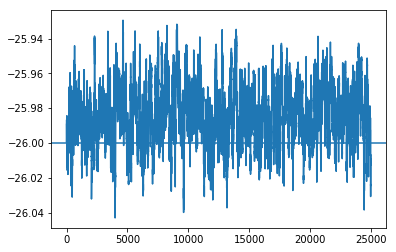

In [10]:
mp.plot(test[0][n_samples/2:])
mp.axhline(abs_bar)
print(np.mean(test[0][n_samples/2:]), np.std(test[0][n_samples/2:]), abs_bar)

-1.0071121836801058 0.009156624993255081 -1.0


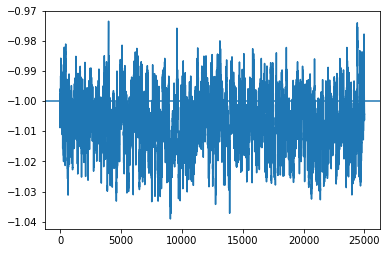

In [11]:
mp.plot(test[1][n_samples/2:])
mp.axhline(s_bar)
print(np.mean(test[1][n_samples/2:]), np.std(test[1][n_samples/2:]), s_bar)

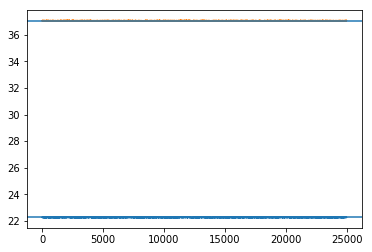

In [12]:
for i in range(n_gal):
    mp.plot(test[2][i][n_samples/2:])
    mp.axhline(mu_true[i])

-5.6426674514566315 0.018488351185679236 -5.621570032324122
-4.832979046428612 0.018612895878517926 -4.83650276025455
-5.714987288614022 0.01856437563638971 -5.702040101875667
-4.973056867411495 0.018723126908840138 -4.970537772441085
-5.291356584989223 0.01860871054063047 -5.275333847796384
-5.452350667704998 0.018575538592298275 -5.44167960303165
-4.869578760371942 0.018501490186428837 -4.8716824566142245
-5.507047320374694 0.01859916110152531 -5.516532162554016
-4.904173311342483 0.018748928962964897 -4.90950482828662
-5.076831114882531 0.01862656501024307 -5.070002097249333


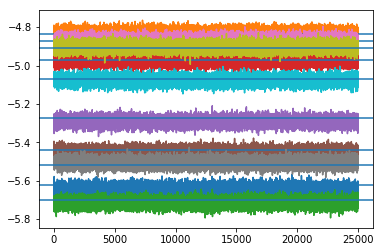

In [13]:
for i in range(10):
    mp.plot(test[3][0, i, n_samples/2:])
    mp.axhline(m_true[0, i])
    print(np.mean(test[3][0, i, n_samples/2:]), np.std(test[3][0, i, n_samples/2:]), m_true[0, i])

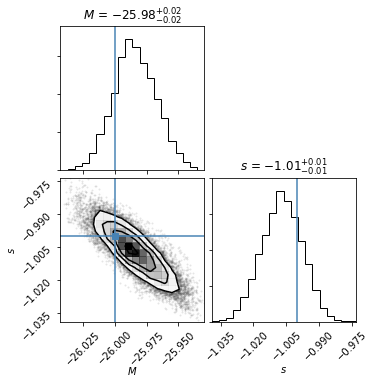

In [14]:
import corner
samples = np.stack((test[0], test[1]))
fig = corner.corner(samples[:, n_samples/2:].T, labels=[r"$M$", r"$s$"],
                    show_titles=True, truths=[abs_bar, s_bar])

In [15]:
import pystan as ps
import pickle

stan_code = """
data {
    int<lower=0> n_gal;
    int<lower=0> n_star;
    real mu_hat;
    real mu_hat_sig;
    real m_hat[n_gal, n_star];
    real m_hat_sig;
    real m_sig_int;
    real lp_true[n_gal, n_star];
    real abs_bar;
    real abs_sig;
    real s_bar;
    real s_sig;
    real mu_bar;
    real mu_sig;
}
parameters {
    real mu_true[n_gal];
    real m_true[n_gal, n_star];
    real abs_true;
    real s_true;
}
model {
    // priors
    abs_true ~ normal(abs_bar, abs_sig);
    s_true ~ normal(s_bar, s_sig);
    mu_true ~ normal(mu_bar, mu_sig);
    
    // whatevers
    for(i in 1: n_gal){
        for(j in 1: n_star){
            m_true[i, j] ~ normal(mu_true[i] + abs_true + s_true * lp_true[i, j], m_sig_int);
        }
    }
    
    // likelihoods
    mu_hat ~ normal(mu_true[1], mu_hat_sig);
    for(i in 1: n_gal){
        for(j in 1: n_star){
            m_hat[i, j] ~ normal(m_true[i, j], m_hat_sig);
        }
    }
}
"""
n_samples_stan = 5000
recompile = False
if recompile:
    stan_model = ps.StanModel(model_code=stan_code)
    with open('bhms_stan_model.pkl', 'wb') as f:
        pickle.dump(stan_model, f)
else:
    try:
        with open('bhms_stan_model.pkl', 'rb') as f:
            stan_model = pickle.load(f)
    except EnvironmentError:
        print('ERROR: pickled Stan model (bhms_stan_model.pkl) not found. ' + \
              'Please set recompile = True')
        exit()

In [16]:
stan_data = {'n_gal': n_gal, 'n_star': n_star, 'mu_hat': mu_hat[0], 'mu_hat_sig': mu_hat_sig, \
             'm_hat': m_hat, 'm_hat_sig': m_hat_sig, 'm_sig_int': m_sig_int, 'lp_true': lp_true, \
             'abs_bar': abs_bar, 'abs_sig': abs_sig, 's_bar': s_bar, 's_sig': s_sig, \
             'mu_bar': mu_bar, 'mu_sig': mu_sig}
fit = stan_model.sampling(data=stan_data, iter=n_samples_stan, chains=4)

/Users/sfeeney/Software_Packages/miniconda2/lib/python2.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [17]:
samples = fit.extract(permuted=True)
print(fit)

Inference for Stan model: anon_model_ab41b39e55c2f57c74acf30e86ea4ea5.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_true[0]     22.26  1.4e-4 9.9e-3  22.24  22.26  22.26  22.27  22.28 5216.0    1.0
mu_true[1]     37.06  1.4e-4   0.01  37.04  37.05  37.06  37.07  37.08 6320.0    1.0
m_true[0,0]    -5.64  1.9e-4   0.02  -5.68  -5.66  -5.64  -5.63  -5.61  10000    1.0
m_true[1,0]     9.41  1.8e-4   0.02   9.37   9.39   9.41   9.42   9.44  10000    1.0
m_true[0,1]    -4.83  1.9e-4   0.02  -4.87  -4.85  -4.83  -4.82   -4.8  10000    1.0
m_true[1,1]     9.85  1.8e-4   0.02   9.81   9.83   9.85   9.86   9.88  10000    1.0
m_true[0,2]    -5.71  1.9e-4   0.02  -5.75  -5.73  -5.71   -5.7  -5.68  10000    1.0
m_true[1,2]     9.09  1.8e-4   0.02   9.05   9.08   9.09    9.1   9.13  10000    1.0
m_true[0,3]    -4.97  1.8e-4   0.02  -5.01  -

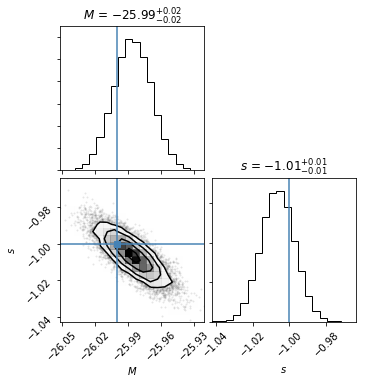

In [18]:
samples = np.stack((samples['abs_true'], samples['s_true']))
fig = corner.corner(samples.T, labels=[r"$M$", r"$s$"],
                    show_titles=True, truths=[abs_bar, s_bar])